In [1]:
import numpy as np,pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold,KFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

pd.set_option('max_columns',200)
pd.set_option('max_rows',200)
pd.set_option('max_colwidth',200)

In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [2]:
%%time
df_train = pd.read_csv('../dataset/train.csv')
df_train.head()

Wall time: 23.7 s


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,NaN,NaN,NaN,0-4


In [4]:
df_train = reduce_memory_usage(df_train)

Mem. usage decreased to 1369.47 Mb (31.9% reduction)


In [36]:
drop_list = []
number_feature = df_train.select_dtypes(include='number').columns
category_feature = df_train.select_dtypes(include='object').columns
for c in df_train.columns:
    n = 100 * df_train[c].isnull().sum()/len(df_train[c])
    if n>50:
        drop_list.append(c)
    elif n>0:
        if c in number_feature:
            df_train[c] = df_train[c].fillna(0)
        elif c in category_feature:
            df_train[c] = df_train[c].fillna('{}'.format(c + '_null'))
        else:
            pass
    else:
        pass
drop_list

['page', 'hover_duration', 'text', 'text_fqid', 'fullscreen', 'hq', 'music']

In [3]:
%%time
labels = pd.read_csv('../dataset/train_labels.csv')
labels['session'] = labels['session_id'].apply(lambda x:int(x.split('_')[0]))
labels['q'] = labels['session_id'].apply(lambda x:int(x.split('q')[1]))
labels.head()

Wall time: 366 ms


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


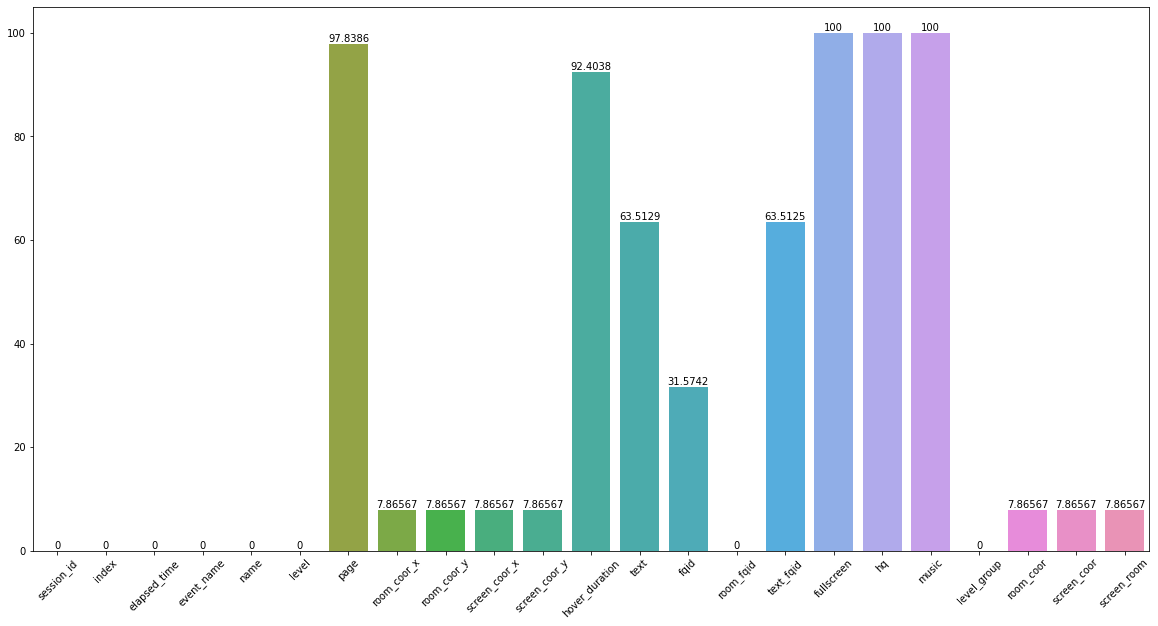

In [25]:
import seaborn as sns
missing_data = df_train.isnull().sum()/len(df_train) * 100
plt.figure(figsize=(20,10))
g = sns.barplot(x = missing_data.index,y = missing_data.values)
g.xaxis.set_tick_params(rotation=45)
g.bar_label(g.containers[0])
plt.show()
del missing_data,g

In [27]:
for n in ['text','fqid','room_fqid','text_fqid']:
    t = len(df_train[n].unique())
    print('The feature {} of number {}'.format(n,t))

The feature text of number 595
The feature fqid of number 128
The feature room_fqid of number 19
The feature text_fqid of number 127


In [28]:
df_train['room_fqid'].value_counts()

tunic.historicalsociety.entry              1816202
tunic.wildlife.center                      1510888
tunic.historicalsociety.cage               1178391
tunic.library.frontdesk                    1075322
tunic.historicalsociety.frontdesk           972235
tunic.historicalsociety.stacks              900673
tunic.historicalsociety.closet_dirty        788096
tunic.humanecology.frontdesk                662645
tunic.historicalsociety.basement            585058
tunic.kohlcenter.halloffame                 547779
tunic.library.microfiche                    497924
tunic.drycleaner.frontdesk                  492050
tunic.historicalsociety.collection          478700
tunic.historicalsociety.closet              429854
tunic.flaghouse.entry                       416942
tunic.historicalsociety.collection_flag     227017
tunic.capitol_1.hall                        223793
tunic.capitol_0.hall                        208670
tunic.capitol_2.hall                        161972
Name: room_fqid, dtype: int64

In [31]:
df_train['room_fqid'].unique().tolist()

['tunic.historicalsociety.closet',
 'tunic.historicalsociety.basement',
 'tunic.historicalsociety.entry',
 'tunic.historicalsociety.collection',
 'tunic.historicalsociety.stacks',
 'tunic.kohlcenter.halloffame',
 'tunic.capitol_0.hall',
 'tunic.historicalsociety.closet_dirty',
 'tunic.historicalsociety.frontdesk',
 'tunic.humanecology.frontdesk',
 'tunic.drycleaner.frontdesk',
 'tunic.library.frontdesk',
 'tunic.library.microfiche',
 'tunic.capitol_1.hall',
 'tunic.historicalsociety.cage',
 'tunic.historicalsociety.collection_flag',
 'tunic.wildlife.center',
 'tunic.flaghouse.entry',
 'tunic.capitol_2.hall']

In [ ]:
ROOM_FQIDS = ['tunic.historicalsociety.closet', 'tunic.historicalsociety.basement', 'tunic.historicalsociety.entry', 
              'tunic.historicalsociety.collection', 'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
              'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty', 'tunic.historicalsociety.frontdesk', 
              'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk', 'tunic.library.frontdesk', 
              'tunic.library.microfiche', 'tunic.capitol_1.hall', 'tunic.historicalsociety.cage', 
              'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center', 'tunic.flaghouse.entry', 
              'tunic.capitol_2.hall']

In [43]:
def featureEng(data):
    NUMS = ['elapsed_time','level','hover_duration','elapsed_time_diff','room_coor_x','room_coor_y','room_coor',
            'screen_coor_x','screen_coor_y','screen_coor','screen_room','room_coor_diff','screen_coor_diff']
    CATS = ['event_name','name','fqid','room_fqid','text']
    EVENTS = ['navigate_click','person_click','cutscene_click','object_click','map_hover','notification_click',
              'map_click','observation_click','checkpoint']
    NAMES = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
    ROOM_FQIDS = ['tunic.historicalsociety.closet', 'tunic.historicalsociety.basement', 'tunic.historicalsociety.entry', 
              'tunic.historicalsociety.collection', 'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
              'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty', 'tunic.historicalsociety.frontdesk', 
              'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk', 'tunic.library.frontdesk', 
              'tunic.library.microfiche', 'tunic.capitol_1.hall', 'tunic.historicalsociety.cage', 
              'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center', 'tunic.flaghouse.entry', 
              'tunic.capitol_2.hall']
    data['room_coor'] = np.sqrt(np.power(data['room_coor_x'],2) + np.power(data['room_coor_y'],2))
    data['screen_coor'] = np.sqrt(np.power(data['screen_coor_x'],2) + np.power(data['screen_coor_y'],2))
    data['screen_room'] = np.sqrt(np.power(data['room_coor_x']-data['screen_coor_x'],2) + np.power(data['room_coor_y'] - data['screen_coor_y'],2))
    users = data['session_id'].unique().tolist()
    groups = data['level_group'].unique().tolist()
    user_data = []
    name_list = ['session_id','level_group']
    for u in tqdm(users):
        datatemp = data[data['session_id']==u].sort_values(by='index')
        datatemp['elapsed_time_diff'] = datatemp['elapsed_time'].diff().values
        datatemp['room_coor_diff'] = datatemp['room_coor'].diff().values
        datatemp['screen_coor_diff'] = datatemp['screen_coor'].diff().values
        for g in groups:
            data_list = []
            temp = datatemp[datatemp['level_group']==g]
            data_list.append(u)
            data_list.append(g)
            for n in NUMS:
                data_list.append(temp[n].mean())
                data_list.append(temp[n].max() - temp[n].min())
            for n in EVENTS:
                data_list.append(temp[temp['event_name']==n]['elapsed_time'].mean())                
                data_list.append(temp[temp['event_name']==n]['elapsed_time'].max() - temp[temp['event_name']==n]['elapsed_time'].min())
            for n in NAMES:
                data_list.append(temp[temp['name']==n]['elapsed_time'].mean())                
                data_list.append(temp[temp['name']==n]['elapsed_time'].max() - temp[temp['name']==n]['elapsed_time'].min())
            for n in ROOM_FQIDS:
                data_list.append(temp[temp['room_fqid']==n]['elapsed_time'].mean())                
                data_list.append(temp[temp['room_fqid']==n]['elapsed_time'].max() - temp[temp['room_fqid']==n]['elapsed_time'].min())
            
            for e in EVENTS:
                temp[e] = (temp['event_name']==e).astype('int8')
            for e in EVENTS:
                try:
                    data_list.append(temp[e].sum())
                except:
                    data_list.append(0)
            for n in NAMES:
                temp[n] = (temp['name']==n).astype('int8')
            for n in NAMES:
                try:
                    data_list.append(temp[n].sum())
                except:
                    data_list.append(0)
            for r in ROOM_FQIDS:
                temp[r] = (temp['room_fqid']==r).astype('int8')
            for r in ROOM_FQIDS:
                try:
                    data_list.append(temp[r].sum())
                except:
                    data_list.append(0)
            user_data.append(data_list)
    for n in NUMS:
        name1 = n + '_mean'
        name2 = n + '_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for n in EVENTS:
        name1 = n + '_elapsed_time_mean'
        name2 = n + '_elapsed_time_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for n in NAMES:
        name1 = n + '_elapsed_time_mean'
        name2 = n + '_elapsed_time_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for n in ROOM_FQIDS:
        name1 = n + '_elapsed_time_mean'
        name2 = n + '_elapsed_time_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for e in EVENTS:
        name = e + '_sum'
        name_list.append(name)
    for n in NAMES:
        name = n + '_sum'
        name_list.append(name)
    for r in ROOM_FQIDS:
        name = r + '_counts'
        name_list.append(name)
    dfs = pd.DataFrame(user_data,columns=name_list)
    dfs = dfs.set_index('session_id')
    return dfs

In [44]:
%%time
train = featureEng(df_train)
train.head()


Wall time: 40min


,level_group,elapsed_time_mean,elapsed_time_sdiff,level_mean,level_sdiff,hover_duration_mean,hover_duration_sdiff,elapsed_time_diff_mean,elapsed_time_diff_sdiff,room_coor_x_mean,room_coor_x_sdiff,room_coor_y_mean,room_coor_y_sdiff,room_coor_mean,room_coor_sdiff,screen_coor_x_mean,screen_coor_x_sdiff,screen_coor_y_mean,screen_coor_y_sdiff,screen_coor_mean,screen_coor_sdiff,screen_room_mean,screen_room_sdiff,room_coor_diff_mean,room_coor_diff_sdiff,screen_coor_diff_mean,screen_coor_diff_sdiff,navigate_click_elapsed_time_mean,navigate_click_elapsed_time_sdiff,person_click_elapsed_time_mean,person_click_elapsed_time_sdiff,cutscene_click_elapsed_time_mean,cutscene_click_elapsed_time_sdiff,object_click_elapsed_time_mean,object_click_elapsed_time_sdiff,map_hover_elapsed_time_mean,map_hover_elapsed_time_sdiff,notification_click_elapsed_time_mean,notification_click_elapsed_time_sdiff,map_click_elapsed_time_mean,map_click_elapsed_time_sdiff,observation_click_elapsed_time_mean,observation_click_elapsed_time_sdiff,checkpoint_elapsed_time_mean,checkpoint_elapsed_time_sdiff,basic_elapsed_time_mean,basic_elapsed_time_sdiff,undefined_elapsed_time_mean,undefined_elapsed_time_sdiff,close_elapsed_time_mean,close_elapsed_time_sdiff,open_elapsed_time_mean,open_elapsed_time_sdiff,prev_elapsed_time_mean,prev_elapsed_time_sdiff,next_elapsed_time_mean,next_elapsed_time_sdiff,tunic.historicalsociety.closet_elapsed_time_mean,tunic.historicalsociety.closet_elapsed_time_sdiff,tunic.historicalsociety.basement_elapsed_time_mean,tunic.historicalsociety.basement_elapsed_time_sdiff,tunic.historicalsociety.entry_elapsed_time_mean,tunic.historicalsociety.entry_elapsed_time_sdiff,tunic.historicalsociety.collection_elapsed_time_mean,tunic.historicalsociety.collection_elapsed_time_sdiff,tunic.historicalsociety.stacks_elapsed_time_mean,tunic.historicalsociety.stacks_elapsed_time_sdiff,tunic.kohlcenter.halloffame_elapsed_time_mean,tunic.kohlcenter.halloffame_elapsed_time_sdiff,tunic.capitol_0.hall_elapsed_time_mean,tunic.capitol_0.hall_elapsed_time_sdiff,tunic.historicalsociety.closet_dirty_elapsed_time_mean,tunic.historicalsociety.closet_dirty_elapsed_time_sdiff,tunic.historicalsociety.frontdesk_elapsed_time_mean,tunic.historicalsociety.frontdesk_elapsed_time_sdiff,tunic.humanecology.frontdesk_elapsed_time_mean,tunic.humanecology.frontdesk_elapsed_time_sdiff,tunic.drycleaner.frontdesk_elapsed_time_mean,tunic.drycleaner.frontdesk_elapsed_time_sdiff,tunic.library.frontdesk_elapsed_time_mean,tunic.library.frontdesk_elapsed_time_sdiff,tunic.library.microfiche_elapsed_time_mean,tunic.library.microfiche_elapsed_time_sdiff,tunic.capitol_1.hall_elapsed_time_mean,tunic.capitol_1.hall_elapsed_time_sdiff,tunic.historicalsociety.cage_elapsed_time_mean,tunic.historicalsociety.cage_elapsed_time_sdiff,tunic.historicalsociety.collection_flag_elapsed_time_mean,tunic.historicalsociety.collection_flag_elapsed_time_sdiff,tunic.wildlife.center_elapsed_time_mean,tunic.wildlife.center_elapsed_time_sdiff,tunic.flaghouse.entry_elapsed_time_mean,tunic.flaghouse.entry_elapsed_time_sdiff,tunic.capitol_2.hall_elapsed_time_mean,tunic.capitol_2.hall_elapsed_time_sdiff,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,basic_sum,undefined_sum,close_sum,open_sum,prev_sum,next_sum,tunic.historicalsociety.closet_counts,tunic.historicalsociety.basement_counts,tunic.historicalsociety.entry_counts,tunic.historicalsociety.collection_counts,tunic.historicalsociety.stacks_counts,tunic.kohlcenter.halloffame_counts,tunic.capitol_0.hall_counts,tunic.historicalsociety.closet_dirty_counts,tunic.historicalsociety.frontdesk_counts,tunic.humanecology.frontdesk_counts,tunic.drycleaner.frontdesk_counts,tunic.library.frontdesk_counts,tunic.library.microfiche_counts,tunic.capitol_1.hall_counts,tunic.historicalsociety.cage_counts,tunic.historicalsociety.collection_flag_counts,tunic.wildlife.center_counts,tunic.f

In [45]:
print(train.shape)
features = [c for c in train.columns if c not in ['level_group']]
all_users = train.index.unique()

(35337, 129)


In [46]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(all_users),18)), index=all_users)
models = {}

for i,(train_index,test_index) in enumerate(gkf.split(X=train, groups=train.index)):
    print('='*80,i,'='*80)
    xgb_params = {
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate':0.005,
        'max_depth':4,
        'n_estimators':2023,
        'early_stopping_rounds':50,
        'tree_method':'hist',
        'subsample':0.8,
        'colsample_bytree':0.4,
        'use_label_encoder':False
    }
    for t in range(1,19):
        if t<4: grp='0-4'
        elif t<14: grp = '5-12'
        elif t<22: grp='13-22'
            
        train_x = train.iloc[train_index]
        xtrain = train_x.loc[train_x['level_group']==grp]
        train_users = xtrain.index.values
        ytrain = labels.loc[labels.q==t].set_index('session').loc[train_users]
        
        test_x = train.iloc[test_index]
        xtest = test_x.loc[test_x.level_group==grp]
        test_users = xtest.index.values
        ytest = labels.loc[labels.q==t].set_index('session').loc[test_users]
        
        clf = XGBClassifier(**xgb_params)
        clf.fit(xtrain[features].astype('float32'),ytrain['correct'],
               eval_set=[(xtest[features].astype('float32'),ytest['correct'])],
               verbose=0)
        print(f'{t}({clf.best_ntree_limit}) ; ',end='')
        
        models[f'{grp}_{t}'] = clf
        oof.loc[test_users,t-1] = clf.predict_proba(xtest[features].astype('float32'))[:,1]
    print()

================================================================================ 0 ================================================================================
[08:12:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


1(2023) ; [08:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an is

1(2023) ; [08:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


2(2023) ; [08:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


3(2023) ; [08:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

2(2023) ; [08:17:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


3(2023) ; [08:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


4(2023) ; [08:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

3(2023) ; [08:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


4(2023) ; [08:20:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


5(2023) ; [08:20:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

4(2023) ; [08:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


5(2023) ; [08:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


6(2023) ; [08:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

In [47]:
tval = oof.copy()
for k in range(18):
    temp = labels.loc[labels.q==k+1].set_index('session').loc[all_users]
    tval[k] = temp.correct.values

In [48]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0
for threshold in np.arange(0.4,0.8,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(tval.values.reshape((-1)),preds,average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score=m
        best_threshold = threshold
for k in range(18):
    m = f1_score(tval[k].values,(oof[k].values>best_threshold).astype('int'),average='macro')
    print(f'Q{k}: F1=',m)

m = f1_score(tval.values.reshape((-1)),(oof.values.reshape((-1))>best_threshold).astype('int'),average='macro')
print('==> Overall F1 =',m)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, Q0: F1= 0.6520131302174221
Q1: F1= 0.49457198026174637
Q2: F1= 0.49888073968872904
Q3: F1= 0.6332922367597921
Q4: F1= 0.5989045441743394
Q5: F1= 0.6093235258169563
Q6: F1= 0.606004712378807
Q7: F1= 0.5532464504320376
Q8: F1= 0.6070825006764091
Q9: F1= 0.5407271629283379
Q10: F1= 0.600498485821394
Q11: F1= 0.5117713917644884
Q12: F1= 0.457164962637698
Q13: F1= 0.6170074938249234
Q14: F1= 0.5647878639760758
Q15: F1= 0.4668857485229805
Q16: F1= 0.5432596211835475
Q17: F1= 0.49046484153275705
==> Overall F1 = 0.6845658864595967


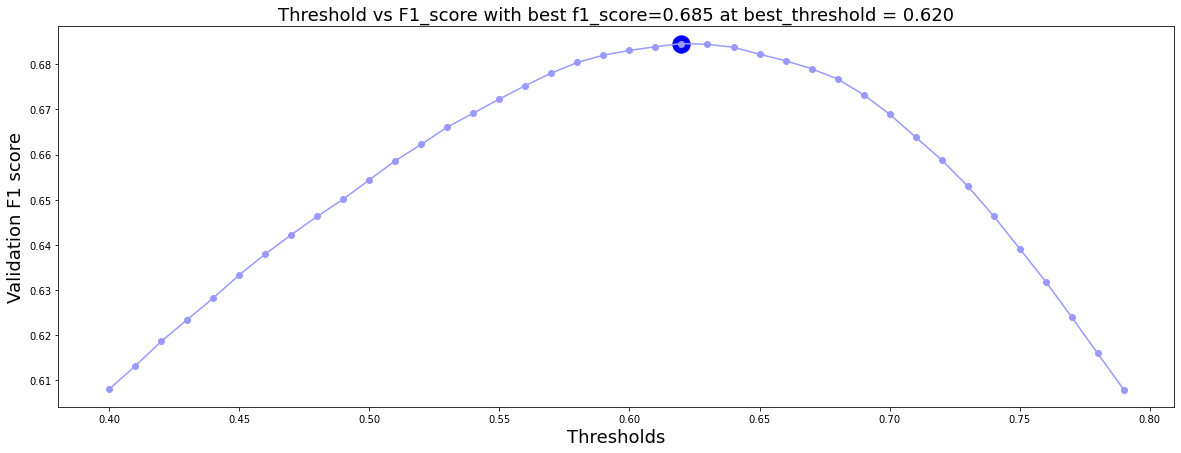

In [49]:
plt.figure(figsize=(20,7))
plt.plot(thresholds,scores,'-o',color='#9999ff')
plt.scatter([best_threshold],[best_score],color='blue',s=300,alpha=1)
plt.xlabel('Thresholds',size=18)
plt.ylabel('Validation F1 score',size=18)
plt.title(f'Threshold vs F1_score with best f1_score={best_score:.3f} at best_threshold = {best_threshold:.3f}',size=18)
plt.show()